In [1]:
import pandas as pd
import numpy as np
import matplotlib as pl
import matplotlib.pyplot as plt 
import mpl_toolkits.basemap as bm
%matplotlib inline

In [2]:
data = pd.read_csv("data.csv")

In [33]:
data.head()
print data.columns

Index([u'DATE', u'TIME', u'BOROUGH', u'ZIP CODE', u'LATITUDE', u'LONGITUDE', u'LOCATION', u'ON STREET NAME', u'CROSS STREET NAME', u'OFF STREET NAME', u'NUMBER OF PERSONS INJURED', u'NUMBER OF PERSONS KILLED', u'NUMBER OF PEDESTRIANS INJURED', u'NUMBER OF PEDESTRIANS KILLED', u'NUMBER OF CYCLIST INJURED', u'NUMBER OF CYCLIST KILLED', u'NUMBER OF MOTORIST INJURED', u'NUMBER OF MOTORIST KILLED', u'CONTRIBUTING FACTOR VEHICLE 1', u'CONTRIBUTING FACTOR VEHICLE 2', u'CONTRIBUTING FACTOR VEHICLE 3', u'CONTRIBUTING FACTOR VEHICLE 4', u'CONTRIBUTING FACTOR VEHICLE 5', u'UNIQUE KEY', u'VEHICLE TYPE CODE 1', u'VEHICLE TYPE CODE 2', u'VEHICLE TYPE CODE 3', u'VEHICLE TYPE CODE 4', u'VEHICLE TYPE CODE 5', u'year', u'month', u'day'], dtype='object')


In [5]:
import datetime
nice_dates = data 
nice_dates["year"] = data["DATE"].apply(lambda x:int(x.split('/')[2]))
nice_dates["month"] = data["DATE"].apply(lambda x:int(x.split('/')[0]))
nice_dates["day"] = data["DATE"].apply(lambda x:int(x.split('/')[1]))
grouped_by_year = data.groupby(by=["year"])
grouped_by_month = data.groupby(by=["month"])

year
2012    100522
2013    203689
2014    205928
2015    203608
dtype: int64


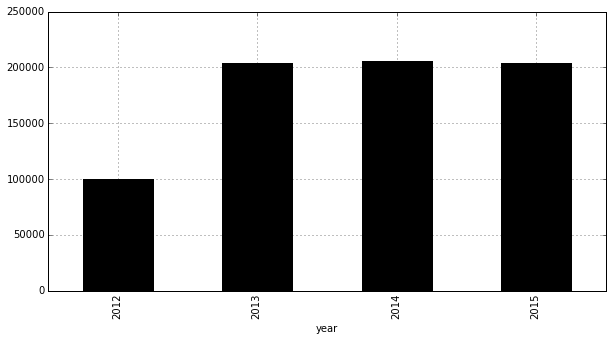

In [6]:
group_sizes = grouped_by_year.size()
fig = plt.figure(figsize=(10,5))
group_sizes.plot(kind='bar', color='k')
print group_sizes

month
1        48392
2        45824
3        50293
4        49576
5        56011
6        55396
7        70756
8        69946
9        69797
10       72481
11       68601
12       56674
dtype: int64


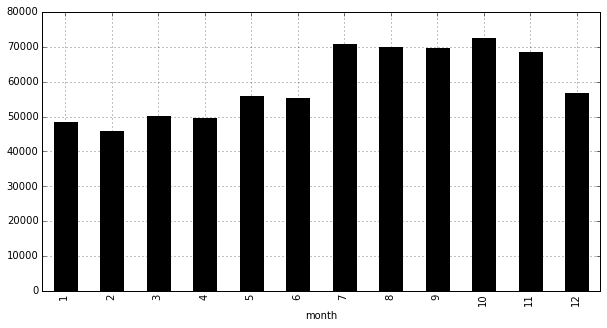

In [7]:
group_sizes = grouped_by_month.size()
fig = plt.figure(figsize=(10,5))
group_sizes.plot(kind='bar', color='k')
print group_sizes

In [11]:
def transform(x):
    return "{0}/{1}/{2}".format(*x.split('/'))
nice_dates["DATE"] = data["DATE"].apply(transform)

In [12]:
grouped_by_date = data.groupby(by=["DATE"])

In [48]:
grouped_by_vehicle = data.groupby(by="VEHICLE TYPE CODE 1")
print grouped_by_vehicle.groups.keys()

['TAXI', 'SMALL COM VEH(4 TIRES)', 'FIRE TRUCK', 'VAN', 'PEDICAB', 'BUS', 'UNKNOWN', 'SCOOTER', 'AMBULANCE', 'LIVERY VEHICLE', 'SPORT UTILITY / STATION WAGON', 'OTHER', 'MOTORCYCLE', 'BICYCLE', 'LARGE COM VEH(6 OR MORE TIRES)', 'PASSENGER VEHICLE', 'PICK-UP TRUCK']


In [51]:
v = pd.tseries.index. DatetimeIndex(data["DATE"])

In [54]:
data['date'] = v

(195,
 5,
 [-74.25559136315213, 40.496115395168516, 0.0, 0.0],
 [-73.70000906321046, 40.915532776502616, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x7f74c69f7f10>)

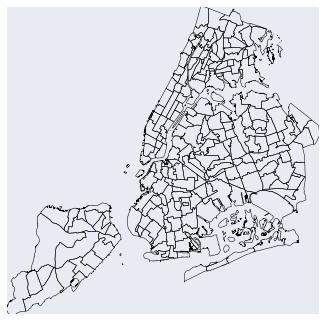

In [64]:

coords = (
           data["LONGITUDE"].min(), data["LATITUDE"].min(),
           data["LONGITUDE"].max(), data["LATITUDE"].max(),
        )

w, h = coords[2] - coords[0], coords[3] - coords[1]

m = bm.Basemap(
    projection='tmerc',
    lon_0=-74.130559,
    lat_0=40.703493,
    ellps = 'WGS84',
    llcrnrlon=coords[0],
    llcrnrlat=coords[1],
    urcrnrlon=coords[2],
    urcrnrlat=coords[3],
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    './ny/ny',
    'NY',
    zorder=2)


In [81]:
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
#print m.NY_info
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.NY],
    })
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000

from descartes import PolygonPatch
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#000000',
    zorder=4
    ))


def get_marker_by_name(name):
    
    colors = ["green", "red", "yellow", "gray", "brown", "black", "pink"]
    shapes = ['o', 'v', '^', '<', '>', 's', 'p']
    
    
    h =  hash(name)%len(colors)
    return (colors[h], shapes[h])
    

    

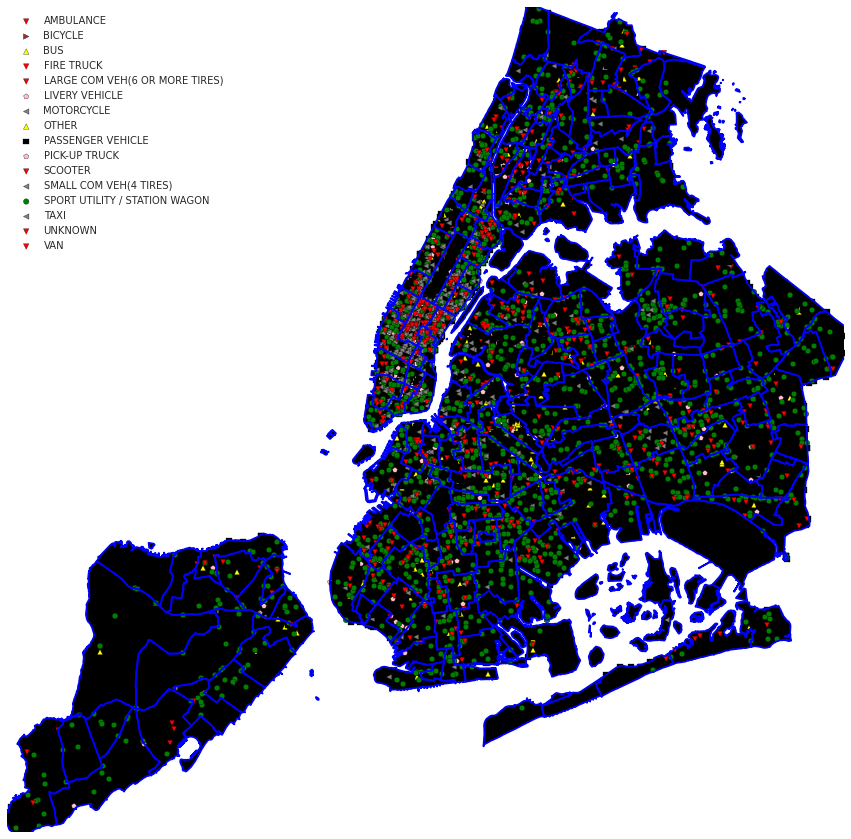

In [95]:
def draw_points(series, name = "", color = "green", max_num = None):
    if max_num is not None:
        series = series[:max_num]
    
    color, shape = get_marker_by_name(name)
    default_size = 30
    res = m.scatter(
        [p for p in series["LONGITUDE"]],
        [p for p in series["LATITUDE"]],
        s=default_size,
        marker=shape, 
        facecolor=color, 
        latlon=True,
        label=name, 
        zorder=1,
    )
    return res

from matplotlib.collections import PatchCollection
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

#for administrative boundaries
for info, shape in zip(m.NY_info, m.NY):
          x, y = zip(*shape) 
          m.plot(x, y,color='b')

#for ground
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True)) 

for idx,  groupdata in enumerate(data[data["year"] == 2015][:10000].groupby("VEHICLE TYPE CODE 1")):
    name, group = groupdata
    res = draw_points(group, name = name)
    plt.legend(loc=0)


fig.set_size_inches(15,15)
